Dataset Metadata:
Years Available: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


C:\Users\tilma\AppData\Local\Temp\ipykernel_51780\323688935.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


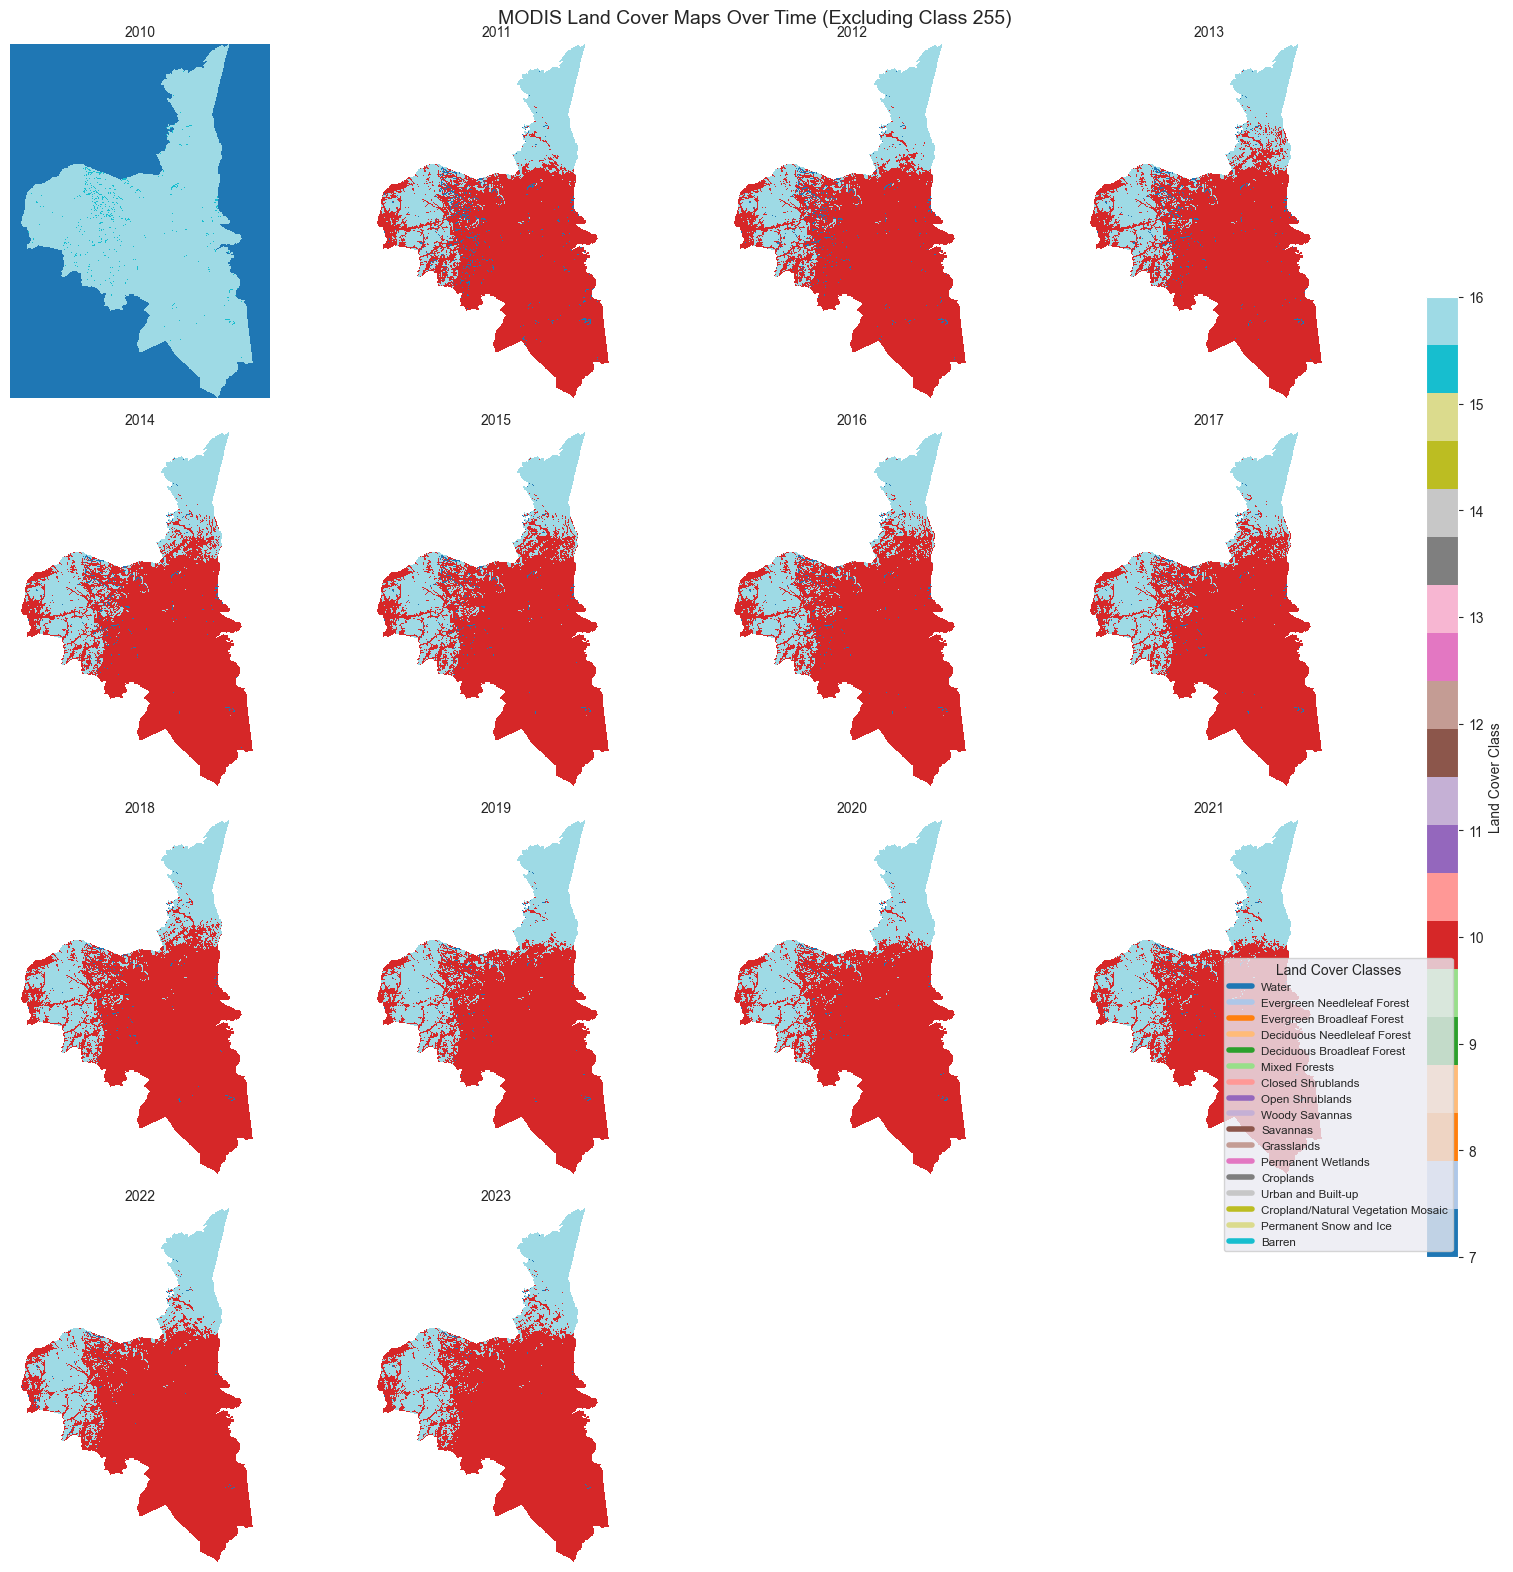

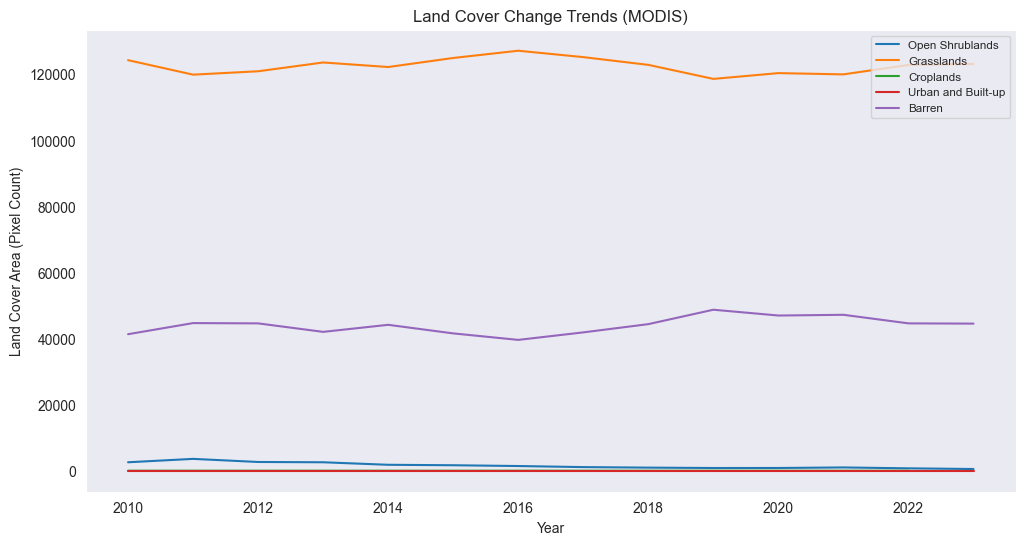

C:\Users\tilma\AppData\Local\Temp\ipykernel_51780\323688935.py:131: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(temp_path))


✅ Land Cover Change GIF saved as 'land_cover_change.gif'


,Open Shrublands,Grasslands,Croplands,Urban and Built-up,Barren
2010,1.522484,73.897225,0.004161,0.004756,24.571374
2011,2.133023,71.288612,NaN,0.004756,26.573609
2012,1.574204,71.898557,0.000594,0.004756,26.521889
2013,1.521889,73.480489,NaN,0.004756,24.992866
2014,1.068889,72.662474,0.001189,0.004756,26.262692
2015,0.986850,74.290776,0.000594,0.004756,24.717024
2016,0.845362,75.596271,0.004161,0.004756,23.549450
2017,0.652153,74.442370,NaN,0.004756,24.900721
2018,0.558224,73.051863,0.000594,0.004756,26.384562
2019,0.491047,70.524695,0.000594,0.004756,28.978908


In [5]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import math
import seaborn as sns
import imageio
from collections import defaultdict
import pandas as pd

# 🔹 Set the folder containing MODIS Land Cover TIFF files
data_folder = "Datasets_Hackathon 1/Datasets_Hackathon/Modis_Land_Cover_Data"  # Change to your actual folder path

# ✅ Define Correct MODIS Land Cover Classes (Excluding 255)
land_cover_classes = {
    0: "Water",
    1: "Evergreen Needleleaf Forest",
    2: "Evergreen Broadleaf Forest",
    3: "Deciduous Needleleaf Forest",
    4: "Deciduous Broadleaf Forest",
    5: "Mixed Forests",
    6: "Closed Shrublands",
    7: "Open Shrublands",
    8: "Woody Savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent Wetlands",
    12: "Croplands",
    13: "Urban and Built-up",
    14: "Cropland/Natural Vegetation Mosaic",
    15: "Permanent Snow and Ice",
    16: "Barren"  # Use for unknowns
}

# ✅ Remove Invalid Classes (255)
valid_classes = set(land_cover_classes.keys())  # Allow only defined land cover categories

# 🔹 Store Data
land_cover_data = {}  # Stores raster arrays per year
land_cover_stats = {}  # Stores land cover distribution per year
years = []  # Store available years

# 🔹 Load all TIFF files in the folder
for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".tif"):  # Process only .tif files
        year = int(filename[:4])  # Extract the year from filename (e.g., "2010LCT.tif")
        years.append(year)
        file_path = os.path.join(data_folder, filename)

        with rasterio.open(file_path) as src:
            raw_data = src.read(1)  # Read the first band (land cover classes)

            # ✅ Remove invalid class 255 (Unclassified)
            cleaned_data = np.where(raw_data == 255, np.nan, raw_data)
            land_cover_data[year] = cleaned_data

            # ✅ Compute statistics for land cover distribution (excluding invalid pixels)
            unique, counts = np.unique(cleaned_data[~np.isnan(cleaned_data)], return_counts=True)
            land_cover_stats[year] = {int(k): v for k, v in zip(unique, counts) if int(k) in valid_classes}

# 🔹 Display Dataset Metadata
print("Dataset Metadata:")
print(f"Years Available: {years}")

# ✅ Grid Layout for Visualization
num_years = len(years)
cols = 4  # Number of columns in the grid (adjust as needed)
rows = math.ceil(num_years / cols)  # Automatically calculate required rows

# 🔹 Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust figure size
axes = axes.flatten()

# 🔹 Loop through each year and plot land cover data
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"{year}", fontsize=10)
    im = ax.imshow(land_cover_data[year], cmap="tab20", interpolation="nearest")
    ax.axis("off")  # Hide axis for cleaner visualization

# 🔹 Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 🔹 Add a colorbar (common for all subplots)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position the colorbar
fig.colorbar(im, cax=cbar_ax, label="Land Cover Class")

# 🔹 Add Class Labels to Legend
legend_patches = [plt.Line2D([0], [0], color=plt.cm.tab20(i / len(valid_classes)), lw=4, label=label)
                  for i, (lc, label) in enumerate(land_cover_classes.items()) if lc in valid_classes]
plt.legend(handles=legend_patches, loc='lower right', fontsize="small", title="Land Cover Classes")

# 🔹 Show final grid layout
plt.suptitle("MODIS Land Cover Maps Over Time (Excluding Class 255)", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
plt.show()

# 🔹 Analyze Land Cover Change Over Time
land_cover_trends = defaultdict(list)

for year in years:
    for lc_class, count in land_cover_stats[year].items():
        land_cover_trends[lc_class].append((year, count))

# 🔹 Plot Trends for Key Land Cover Classes
plt.figure(figsize=(12, 6))
for lc_class, trend in land_cover_trends.items():
    years_list, values = zip(*trend)
    plt.plot(years_list, values, label=land_cover_classes.get(lc_class, f"Class {lc_class}"))

plt.xlabel("Year")
plt.ylabel("Land Cover Area (Pixel Count)")
plt.title("Land Cover Change Trends (MODIS)")
plt.legend(loc="upper right", fontsize="small")
plt.grid()
plt.show()

# 🔹 Create Land Cover Animation Over Time
gif_frames = []
for year in years:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"Land Cover Change ({year})")
    im = ax.imshow(land_cover_data[year], cmap="tab20", interpolation="nearest")
    plt.colorbar(im, ax=ax)

    # Save each frame
    temp_path = f"frame_{year}.png"
    plt.savefig(temp_path)
    plt.close()
    gif_frames.append(imageio.imread(temp_path))
    os.remove(temp_path)  # Remove temp files after saving

# 🔹 Save GIF Animation
imageio.mimsave("land_cover_change.gif", gif_frames, duration=1)
print("✅ Land Cover Change GIF saved as 'land_cover_change.gif'")

# 🔹 Generate Summary Statistics
summary_stats = {}

for year, stats in land_cover_stats.items():
    total_pixels = sum(stats.values())
    summary_stats[year] = {land_cover_classes.get(k, f"Class {k}"): (v / total_pixels) * 100 for k, v in stats.items()}

df_summary = pd.DataFrame(summary_stats).T
df_summary


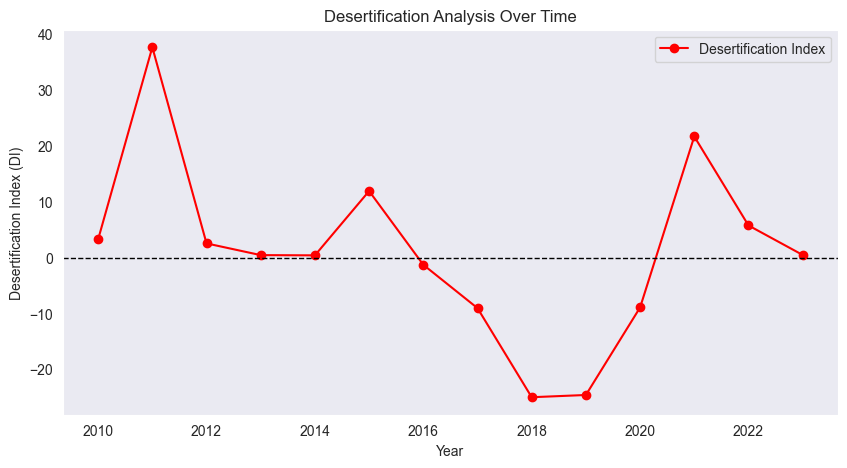

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Extract land cover classes of interest (ensure valid keys exist)
barren_trend = land_cover_trends.get(16, [])  # Barren Land
vegetation_trend = land_cover_trends.get(7, []) + land_cover_trends.get(10, [])  # Shrubs + Grasslands

# ✅ Convert lists of tuples [(year, count), (year, count)] into separate arrays
years_barren, barren_values = zip(*barren_trend) if barren_trend else ([], [])
years_vegetation, vegetation_values = zip(*vegetation_trend) if vegetation_trend else ([], [])

# ✅ Ensure both lists are the same length (only process overlapping years)
common_years = list(set(years_barren) & set(years_vegetation))
common_years.sort()

# 🔹 Get only values for matching years
barren_values = [barren_values[years_barren.index(y)] for y in common_years]
vegetation_values = [vegetation_values[years_vegetation.index(y)] for y in common_years]

# 🔹 Compute changes over time (first-order difference)
delta_barren = np.gradient(barren_values)  # Change in barren land
delta_vegetation = np.gradient(vegetation_values)  # Change in vegetation

# 🔹 Load Climate Data (Dummy values - replace with actual GEE queries)
delta_temperature = np.linspace(0.1, 0.5, len(common_years))  # Fake temperature trend
delta_rainfall = np.linspace(-5, 5, len(common_years))  # Fake rainfall trend

# ✅ Compute the Desertification Index (DI)
DI = (delta_barren / (np.array(delta_vegetation) + 1e-6)) + (delta_temperature / (delta_rainfall + 1e-6))

# 🔹 Plot the Desertification Index
plt.figure(figsize=(10, 5))
plt.plot(common_years, DI, marker="o", linestyle="-", color="red", label="Desertification Index")
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Reference line
plt.xlabel("Year")
plt.ylabel("Desertification Index (DI)")
plt.title("Desertification Analysis Over Time")
plt.legend()
plt.grid()
plt.show()


C:\Users\tilma\AppData\Local\Temp\ipykernel_51780\3153138388.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


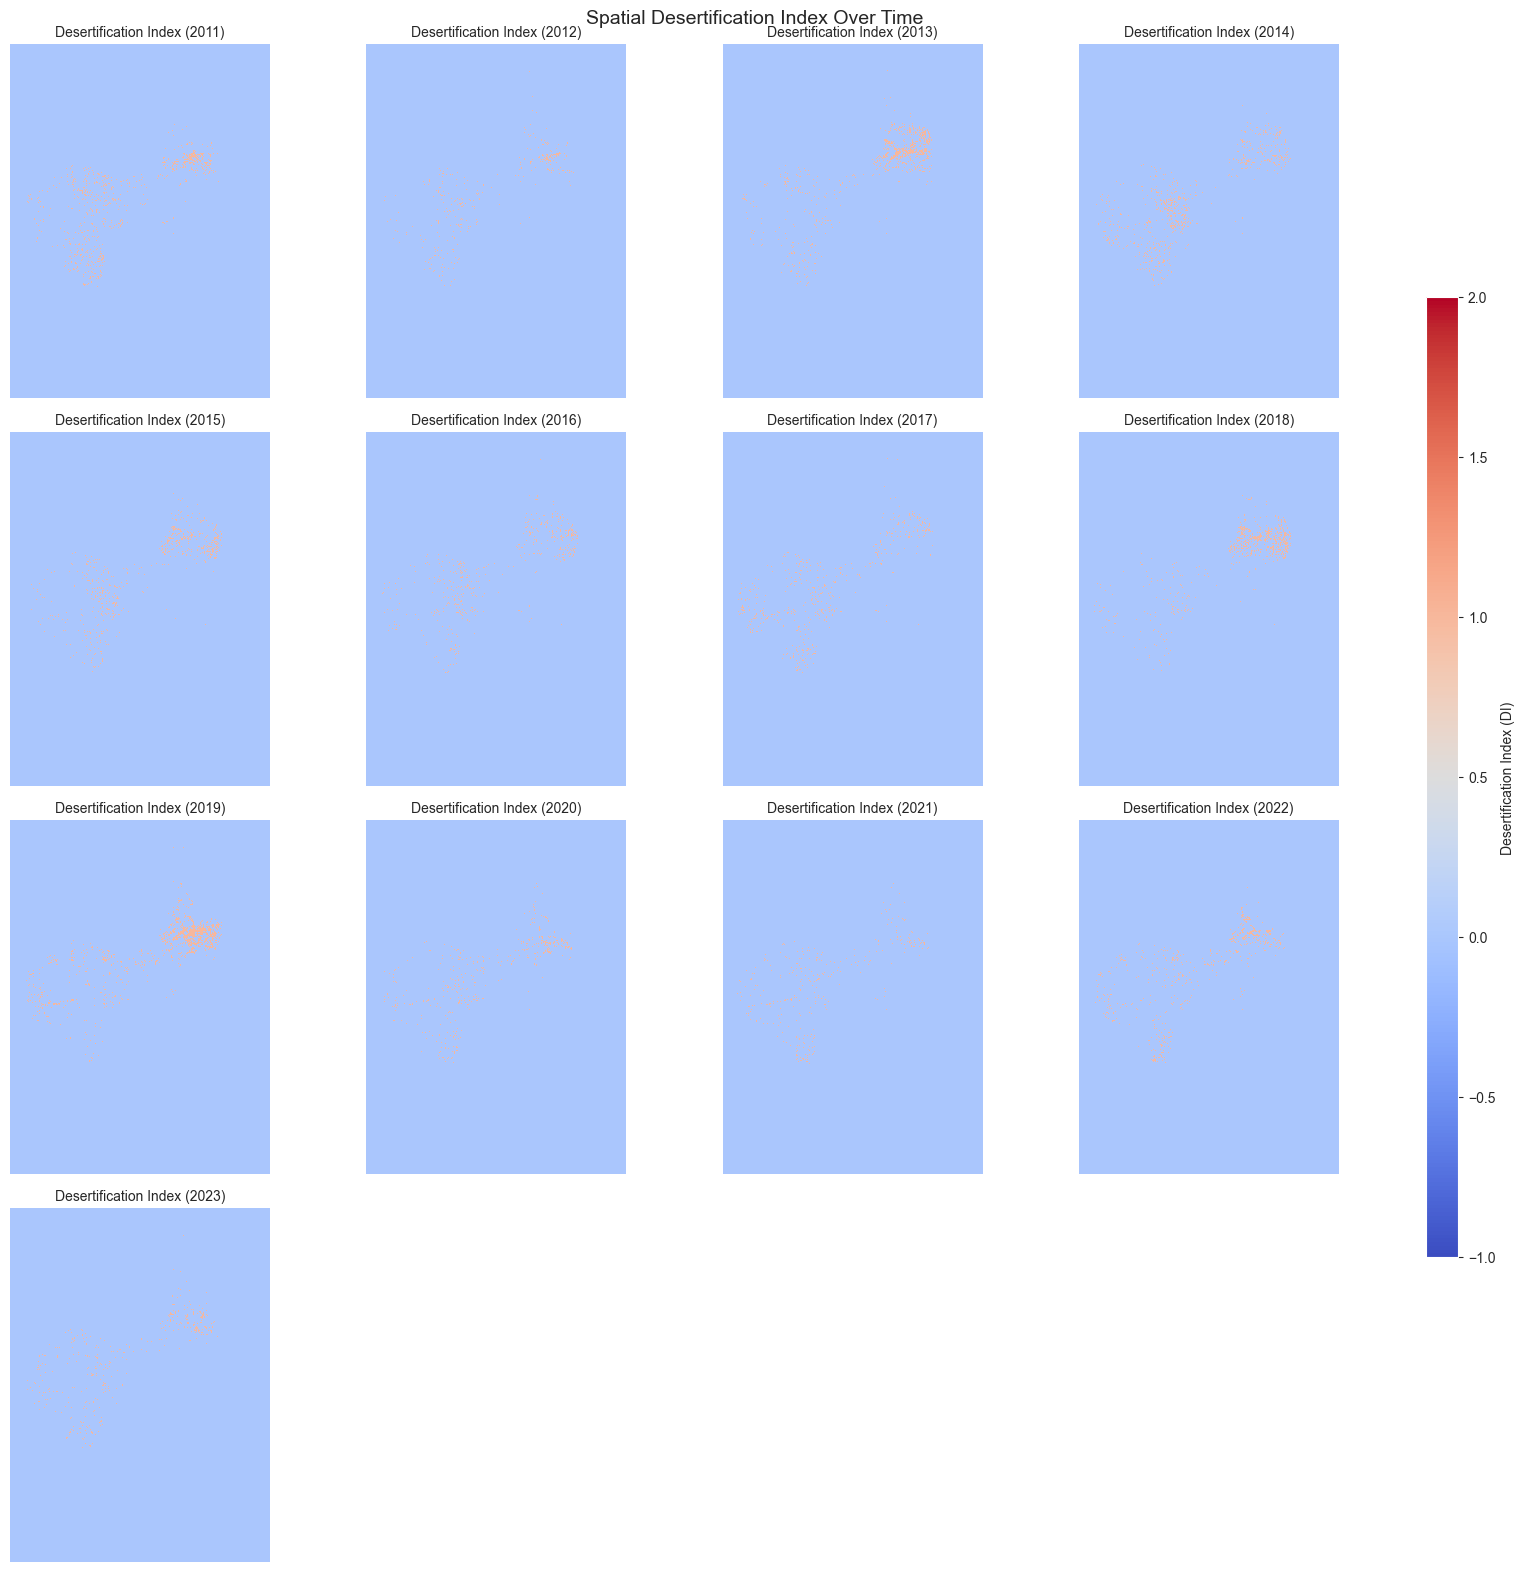

C:\Users\tilma\AppData\Local\Temp\ipykernel_51780\3153138388.py:100: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(temp_path))


✅ Desertification Index GIF saved as 'desertification_index.gif'


In [14]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import math
import imageio

# 🔹 Set the folder containing MODIS Land Cover TIFF files
data_folder = "Datasets_Hackathon 1/Datasets_Hackathon/Modis_Land_Cover_Data"

# ✅ Load Climate Data (Replace with Real Data)
temperature_trend = np.linspace(0.1, 0.5, len(os.listdir(data_folder)))  # Dummy values
rainfall_trend = np.linspace(-5, 5, len(os.listdir(data_folder)))  # Dummy values

# ✅ Initialize Data Storage
land_cover_data = {}
barren_data = {}  # Stores barren land per year
vegetation_data = {}  # Stores vegetation per year (Shrubs + Grasslands)
years = []

# ✅ Load all TIFF files in the folder
for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".tif"):
        year = int(filename[:4])  # Extract the year
        years.append(year)
        file_path = os.path.join(data_folder, filename)

        with rasterio.open(file_path) as src:
            raw_data = src.read(1)

            # ✅ Remove invalid values (255)
            cleaned_data = np.where(raw_data == 255, np.nan, raw_data)
            land_cover_data[year] = cleaned_data

            # ✅ Extract specific land cover types
            barren_data[year] = np.where(cleaned_data == 16, 1, 0)  # Barren = 1, else 0
            vegetation_data[year] = np.where((cleaned_data == 7) | (cleaned_data == 10), 1, 0)  # Shrubs/Grasslands = 1

# ✅ Compute Yearly Changes in Barren and Vegetation Areas
delta_barren = {}
delta_vegetation = {}

for i in range(1, len(years)):
    year_prev = years[i - 1]
    year_curr = years[i]

    delta_barren[year_curr] = barren_data[year_curr] - barren_data[year_prev]  # Change in barren land
    delta_vegetation[year_curr] = vegetation_data[year_curr] - vegetation_data[year_prev]  # Change in vegetation

# ✅ Compute the Desertification Index (DI) for Each Year
desertification_index = {}

for i in range(1, len(years)):
    year_curr = years[i]

    # Compute DI using pixel-wise calculations
    DI = (delta_barren[year_curr] / (-delta_vegetation[year_curr] + 1e-6)) #+ \
        # (temperature_trend[i] / (rainfall_trend[i] + 1e-6))

    desertification_index[year_curr] = DI  # Store spatial DI values

# ✅ Visualization: Desertification Index Maps Over Time
num_years = len(desertification_index)
cols = 4
rows = math.ceil(num_years / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for i, year in enumerate(desertification_index.keys()):
    ax = axes[i]
    ax.set_title(f"Desertification Index ({year})", fontsize=10)
    im = ax.imshow(desertification_index[year], cmap="coolwarm", interpolation="nearest", vmin=-1, vmax=2)
    ax.axis("off")  # Hide axis for cleaner visualization

# ✅ Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ✅ Add colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax, label="Desertification Index (DI)")

# ✅ Show final grid layout
plt.suptitle("Spatial Desertification Index Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# ✅ Create an animation of Desertification Index over time
gif_frames = []
for year in desertification_index.keys():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"Desertification Index ({year})")
    im = ax.imshow(desertification_index[year], cmap="coolwarm", interpolation="nearest", vmin=-1, vmax=2)
    plt.colorbar(im, ax=ax)

    temp_path = f"desertification_{year}.png"
    plt.savefig(temp_path)
    plt.close()
    gif_frames.append(imageio.imread(temp_path))
    os.remove(temp_path)

imageio.mimsave("desertification_index.gif", gif_frames, duration=1)
print("✅ Desertification Index GIF saved as 'desertification_index.gif'")


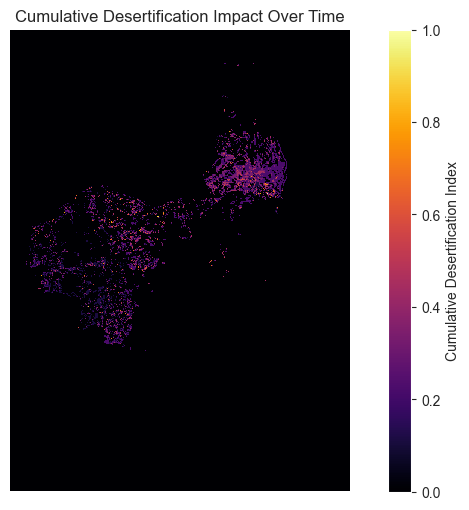

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# ✅ Compute the Cumulative Desertification Index
cumulative_DI = np.zeros_like(next(iter(desertification_index.values())))  # Initialize with zeros

for year in desertification_index.keys():
    cumulative_DI += np.nan_to_num(desertification_index[year])  # Sum up DI over all years

# ✅ Normalize the cumulative DI for visualization
cumulative_DI = (cumulative_DI - np.min(cumulative_DI)) / (np.max(cumulative_DI) - np.min(cumulative_DI))

# ✅ Plot the Overlapped Desertification Map
plt.figure(figsize=(10, 6))
plt.title("Cumulative Desertification Impact Over Time")
im = plt.imshow(cumulative_DI, cmap="inferno", interpolation="nearest")
plt.colorbar(label="Cumulative Desertification Index")
plt.axis("off")  # Hide axes for cleaner visualization
plt.savefig("cumulative_desertification.png", dpi=300, bbox_inches='tight')
plt.show()
